# House Prices: Advanced Regression Techniques

## House Prices: Advanced Regression Techniques

#### Team Name: MLGW4
#### Score: 0.11878
#### Rank: top 14%

#### Global hyperpameters

In [1]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

#### python imports and inits

In [2]:
from rmltk import explain, evaluate, model                        # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
import time                                                       # for timers
from sklearn.preprocessing import OneHotEncoder                   # for one-hot encoding
import xgboost as xgb                                             #xgboost for modeling
from math import exp, expm1                                       #make exponential
import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from D:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\edu_a\AppData\Local\Temp\tmp18ul55bf
  JVM stdout: C:\Users\edu_a\AppData\Local\Temp\tmp18ul55bf\h2o_edu_a_started_from_python.out
  JVM stderr: C:\Users\edu_a\AppData\Local\Temp\tmp18ul55bf\h2o_edu_a_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,"7 days, 23 hours and 46 minutes"
H2O_cluster_name:,H2O_from_python_edu_a_0w4ifn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,24 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


## 1. Explore, and Prepare UCI Credit Card Default Data

#### Import data and reformat

In [3]:
df_train = pd.read_csv('https://gwu-workshop-kai.s3.amazonaws.com/train.csv')
test = pd.read_csv('https://gwu-workshop-kai.s3.amazonaws.com/test.csv')

#### determine data types

In [4]:
# Categorical boolean mask
mask = df_train.dtypes==object

# filter categorical columns using mask and turn it into a list
cats = df_train.columns[mask].tolist()

#filter numeric/float columns
nums = df_train.columns[~mask].tolist()

#print determine data types
print("Categorical =" , cats)
print()
print("Numeric = ", nums )

Categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numeric =  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'Woo

## Split into to train and validation (before doing data prep!!!)

In [5]:
split_ratio = 0.9 # 90%/10% train/test split

# execute split
split = np.random.rand(len(df_train)) < split_ratio
train = df_train[split]
valid = df_train[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

#summarize test set
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 1317, columns = 81
Validation data rows = 143, columns = 81
Test data rows = 1459, columns = 80


### describe all the categorical values in the original train model -- df_train

In [6]:
#describe categorical data
df_train[cats].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Since **`Utilities`** have only 2 unique values but 1459 out of 1460 values are the same, drop the column.

In [7]:
#drop column
droplist = ["Utilities"]
train = train.drop(columns = droplist)
valid = valid.drop(columns = droplist)
test = test.drop(columns = droplist)

### Summarize and handle missing value of training data

In [8]:
missingsum = df_train.isnull().sum()
misslist = missingsum[missingsum>0].sort_values()
misslist.to_frame(name="Missing Value Counts")

,Missing Value Counts
Electrical,1
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtFinType1,37
BsmtExposure,38
BsmtFinType2,38
GarageCond,81
GarageQual,81


#### remove columns with 15% or more missing values

In [9]:
#set 15% of total rows as threshold
drop_threshold = int(len(df_train) * 0.15)

#set mask
mask = misslist < drop_threshold

#filter the variables
miss = list(misslist.index[mask])
drop = [name for name in misslist.index if name not in miss]

#remove columns stated above
train = train.drop(columns = drop)
valid = valid.drop(columns = drop)
test = test.drop(columns = drop)

#print the missing values, and the dropped values
print("Missing values are:",miss)
print()
print("Drop the following values:",drop)


Missing values are: ['Electrical', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'GarageYrBlt']

Drop the following values: ['LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']


#### determine the type of remaining missing data

In [10]:
#filter the categorical missing variables
miss_cats = [name for name in miss if name in cats]

#filter the numeric missing variables
miss_nums = [name for name in nums if name in miss]

print("Categorical missing variables are:", miss_cats)
print()
print("Categorical numeric variables are:", miss_nums)

Categorical missing variables are: ['Electrical', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType']

Categorical numeric variables are: ['MasVnrArea', 'GarageYrBlt']


#### describe the missing data

In [11]:
#describe the data
print(train[miss_cats].describe())
print()
print(train[miss_nums].describe())

       Electrical MasVnrType BsmtQual BsmtCond BsmtFinType1 BsmtExposure  \
count        1317       1310     1284     1284         1284         1283   
unique          5          4        4        4            6            4   
top         SBrkr       None       TA       TA          Unf           No   
freq         1201        776      581     1184          388          863   

       BsmtFinType2 GarageCond GarageQual GarageFinish GarageType  
count          1283       1247       1247         1247       1247  
unique            6          5          5            3          6  
top             Unf         TA         TA          Unf     Attchd  
freq           1133       1196       1184          551        790  

        MasVnrArea  GarageYrBlt
count  1310.000000  1247.000000
mean    104.696947  1978.626303
std     181.320280    24.582352
min       0.000000  1906.000000
25%       0.000000  1961.500000
50%       0.000000  1980.000000
75%     168.750000  2002.000000
max    1600.000000  20

### impute the data

* **`Electrical`**: Electrical: Electrical system
* **`MasVnrType`**: Masonry veneer type
* **`MasVnrArea`**: Masonry veneer type

For the above variables, filling the missing values with the most frequent records

In [12]:
#set the variable list
var = ["Electrical","MasVnrType","MasVnrArea"]

#use loop to fill the missing value with the most frequent records
for xs in var:
    train[xs] = train[xs].fillna(train[xs].value_counts().index[0])
    valid[xs] = valid[xs].fillna(valid[xs].value_counts().index[0])
    test[xs] = test[xs].fillna(test[xs].value_counts().index[0])

#check the result
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training Electrical missing 0 , valid Electrical missing 0 , test Electrical missing 0
training MasVnrType missing 0 , valid MasVnrType missing 0 , test MasVnrType missing 0
training MasVnrArea missing 0 , valid MasVnrArea missing 0 , test MasVnrArea missing 0


* **`BsmtCond`**: Evaluates the general condition of the basement
* **`BsmtQual`**: Evaluates the height of the basement
* **`BsmtFinType1`**: Rating of basement finished area
* **`BsmtFinType2`**: Rating of basement finished area (if multiple types)
* **`BsmtExposure`**: Refers to walkout or garden level walls

For the above variables, NA means no basement. Filling missing variables to None.

In [13]:
# since NA means there is no basement, we change "NA" to "None"

#set variable name list
var = ["BsmtCond","BsmtQual","BsmtFinType1","BsmtFinType2","BsmtExposure"]

#use loop to change data
for xs in var:
    train[xs] = train[xs].fillna(value = "None")
    valid[xs] = valid[xs].fillna(value = "None")
    test[xs] = test[xs].fillna(value = "None")
    
#double check result
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training BsmtCond missing 0 , valid BsmtCond missing 0 , test BsmtCond missing 0
training BsmtQual missing 0 , valid BsmtQual missing 0 , test BsmtQual missing 0
training BsmtFinType1 missing 0 , valid BsmtFinType1 missing 0 , test BsmtFinType1 missing 0
training BsmtFinType2 missing 0 , valid BsmtFinType2 missing 0 , test BsmtFinType2 missing 0
training BsmtExposure missing 0 , valid BsmtExposure missing 0 , test BsmtExposure missing 0


* **`GarageCond`**: Evaluates the Garage condition
* **`GarageQual`**: Garage quality
* **`GarageFinish`**: Interior finish of the garage
* **`GarageType`**: Garage location
* **`GarageYrBlt`**: Year garage was built

For "GarageCond","GarageQual","GarageFinish","GarageType", NA means no garages.

In [14]:
#set variable name list
var = ["GarageCond","GarageQual","GarageFinish","GarageType"]

#fill missing variables in var with None
for xs in var:
    train[xs] = train[xs].fillna(value = "None")
    valid[xs] = valid[xs].fillna(value = "None")
    test[xs] = test[xs].fillna(value = "None")
    
#filling "GarageYrBlt" with "0"
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(value = 0)
valid['GarageYrBlt'] = valid['GarageYrBlt'].fillna(value = 0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(value = 0)

#double check result
var.append("GarageYrBlt")
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training GarageCond missing 0 , valid GarageCond missing 0 , test GarageCond missing 0
training GarageQual missing 0 , valid GarageQual missing 0 , test GarageQual missing 0
training GarageFinish missing 0 , valid GarageFinish missing 0 , test GarageFinish missing 0
training GarageType missing 0 , valid GarageType missing 0 , test GarageType missing 0
training GarageYrBlt missing 0 , valid GarageYrBlt missing 0 , test GarageYrBlt missing 0


### remove Outlier

In [15]:
var = list(train.columns)
var.remove("Id")
var.remove("SalePrice")

#### check pearson correlation

In [16]:
#check pearson correlation
y_name = "SalePrice"
corr = pd.DataFrame(train[var + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr.sort_values(by ='Pearson Correlation Coefficient',ascending = False ).head(10)

,Pearson Correlation Coefficient
OverallQual,0.792147
GrLivArea,0.711104
GarageCars,0.642622
GarageArea,0.621131
TotalBsmtSF,0.611906
1stFlrSF,0.608325
FullBath,0.569459
TotRmsAbvGrd,0.539120
YearBuilt,0.517244
YearRemodAdd,0.510015


#### OverallQual

        Id  OverallQual
533    534            1
636    637            2
916    917            2
1100  1101            2


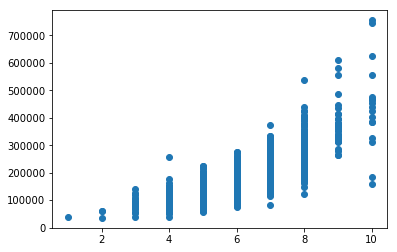

In [17]:
#scatter plot of Overall
plt.scatter(y = train["SalePrice"],x= train["OverallQual"])

#find the index of outlier
print(train[["Id","OverallQual"]].loc[train["OverallQual"]<3])

#store the outlier
out_OQ = list(train.loc[train["OverallQual"]<3].index)

#### GrLivArea

        Id  GrLivArea
523    524       4676
691    692       4316
1182  1183       4476
1298  1299       5642


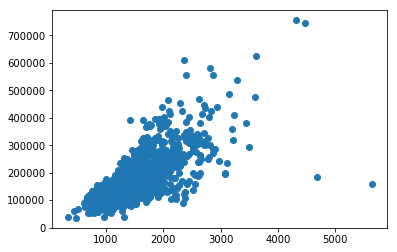

In [18]:
#scatter plot of GrLivArea
plt.scatter(y = train["SalePrice"],x= train["GrLivArea"])

#find the index of outlier
print(train[["Id","GrLivArea"]].loc[train["GrLivArea"]>4000])

#store the outlier
out_GA = list(train["Id"].loc[train["GrLivArea"]>4000].index)

#### GarageCars

        Id  SalePrice
691    692     755000
1182  1183     745000


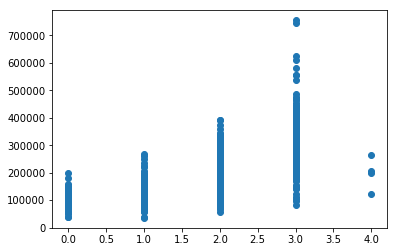

In [19]:
#scatter plot of GarageCars
plt.scatter(y = train["SalePrice"],x= train["GarageCars"])

#find the index of outlier
print(train[["Id","SalePrice"]].loc[train["SalePrice"]>700000])

#store the outlier
out_GC = list(train["Id"].loc[train["SalePrice"]>700000].index)

#### GarageArea

        Id  SalePrice
581    582     253293
825    826     385000
1061  1062      81000
1298  1299     160000


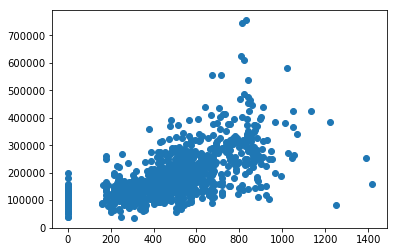

In [20]:
#scatter plot of GarageArea
plt.scatter(y = train["SalePrice"],x= train["GarageArea"])

#find the index of outlier
print(train[["Id","SalePrice"]].loc[train["GarageArea"]>1200])

#store the outlier      
out_GA2 = list(train["Id"].loc[train["GarageArea"]>1200].index)

#### TotalBsmtSF

        Id  SalePrice
332    333     284000
440    441     555000
523    524     184750
1298  1299     160000


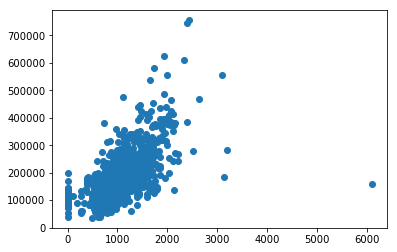

In [21]:
#scatter plot
plt.scatter(y = train["SalePrice"],x= train["TotalBsmtSF"])

#show the outlier Id
print(train[["Id","SalePrice"]].loc[train["TotalBsmtSF"]>3000])

#save the id
out_TB = list(train["Id"].loc[train["TotalBsmtSF"]>3000].index)

#### 1stFlrSF

        Id  SalePrice
1298  1299     160000


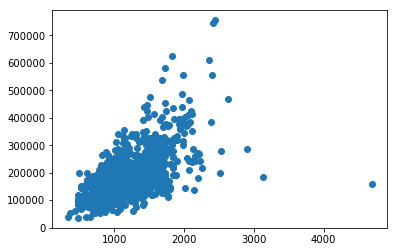

In [22]:
#scatter plot
plt.scatter(y = train["SalePrice"],x= train["1stFlrSF"])

#show the outlier Id
print(train[["Id","SalePrice"]].loc[train["1stFlrSF"]>4000])

#save the id
out_1SF = list(train["Id"].loc[train["1stFlrSF"]>4000].index)

#### YearBuilt

      Id  SalePrice
185  186     475000


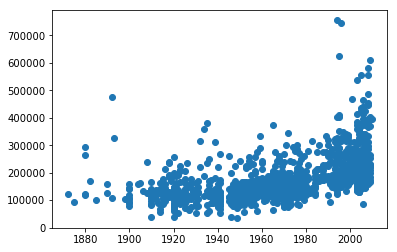

In [23]:
plt.scatter(y = train["SalePrice"],x= train["YearBuilt"])

out = train[(train["YearBuilt"]<1900) & (train["SalePrice"]>400000)]
print(out[["Id","SalePrice"]])

out_YB = list(out.index)

In [24]:
#outliers
out = []
names = [out_OQ, out_GA,out_GA2,out_GC,out_TB,out_1SF,out_YB]
for xs in names:
    for n in xs:
        out.append(n)

#print the outlier id
print(out)

#remove all outliers
train = train.drop(out,axis = 0)

#double check the shape
train.shape

[533, 636, 916, 1100, 523, 691, 1182, 1298, 581, 825, 1061, 1298, 691, 1182, 332, 440, 523, 1298, 1298, 185]


(1303, 74)

## 2. Train Models

##### boxplot the SalePrice

{'boxes': [<matplotlib.lines.Line2D at 0x1d974aea8d0>],
 'caps': [<matplotlib.lines.Line2D at 0x1d974af4320>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d974af4f98>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d974af4b70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d974aeaa20>,
  <matplotlib.lines.Line2D at 0x1d974aeaeb8>]}

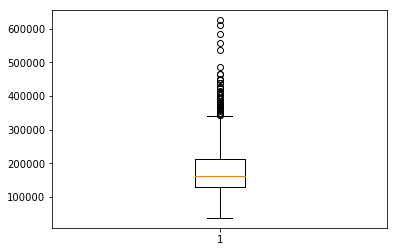

In [25]:
plt.boxplot(train["SalePrice"])

#### log transform of Y variable -- SalePrice

1    12.109011
2    12.317167
3    11.849398
4    12.429216
5    11.870600
Name: SalePrice, dtype: float64


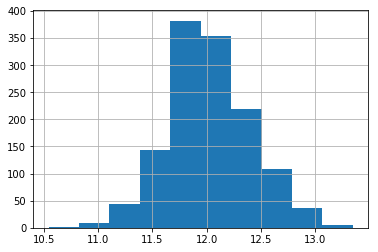

In [26]:
#check log transformation on the "SalePrice" -looks good
train["SalePrice"].apply(np.log).hist()
#valid["SalePrice"].apply(np.log).hist()

#apply log transformation
train["SalePrice"] = np.log(train["SalePrice"])
valid["SalePrice"] = np.log(valid["SalePrice"])
print(train["SalePrice"].head())

{'boxes': [<matplotlib.lines.Line2D at 0x1d974bccbe0>],
 'caps': [<matplotlib.lines.Line2D at 0x1d974bd3630>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d974bda2e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d974bd3e80>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d974bccd30>,
  <matplotlib.lines.Line2D at 0x1d974bd3208>]}

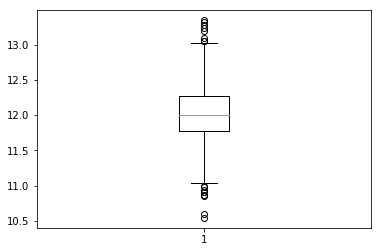

In [27]:
#check the boxplot
plt.boxplot(train["SalePrice"])

In [28]:
#remove the outlier
out = train[train["SalePrice"]<10.75].index
train.drop(out,axis=0,inplace = True)

### create dummy variables

In [29]:
#deep copy the data frame
train_glm = train.copy()
valid_glm = valid.copy()
test_glm = test.copy()

# Categorical boolean mask
mask = train_glm.dtypes==object

# filter categorical columns using mask and turn it into a list
cats = train_glm.columns[mask].tolist()

#### one-hot encode vategorical variables

In [30]:
#one-hot encode training frame
train_glm = pd.get_dummies(train_glm)
train_SP = train_glm["SalePrice"]

#one-hot encode test frame
valid_glm = pd.get_dummies(valid_glm)
valid_SP = valid_glm["SalePrice"]


#keep only the same new columns in the encoded new frames
train_diff_cols = list(set(train_glm.columns) - set(valid_glm.columns))
valid_diff_cols = list(set(valid_glm.columns) - set(train_glm.columns))
train_glm.drop(train_diff_cols, axis=1, inplace=True)
valid_glm.drop(valid_diff_cols, axis=1, inplace=True)


#check that columns are actually the same in both frames
print(train_glm.shape)
print(valid_glm.shape)
print(all(train_glm.columns == valid_glm.columns))

#one-hot encode test frame
test_glm = pd.get_dummies(test_glm)

#keep only the same new columns in the encoded new frames
train_diff_cols = list(set(train_glm.columns)-set(test_glm.columns))
train_glm.drop(train_diff_cols, axis=1, inplace=True)
valid_glm.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_glm.shape)
print(valid_glm.shape)
print(all(train_glm.columns == valid_glm.columns))

#remove columns in encoded test not in encoded train and vals
train_diff_cols = list(set(test_glm.columns)-set(train_glm.columns))
test_glm.drop(train_diff_cols, axis = 1, inplace = True)

#check that columns are actually the same in all encoded frames
print(train_glm.shape)
print(valid_glm.shape)
print(test_glm.shape)
print(all(train_glm.columns == valid_glm.columns)
      and all(valid_glm.columns == test_glm.columns))

#add the SalePrice column to the train and valid
train_glm["SalePrice"] = train_SP
valid_glm["SalePrice"] = valid_SP

#check the shape
print(train_glm.shape)
print(valid_glm.shape)

(1301, 224)
(143, 224)
True
(1301, 222)
(143, 222)
True
(1301, 222)
(143, 222)
(1459, 222)
True
(1301, 223)
(143, 223)


### 2.1 GLM feature selection

#### assign model roles

In [31]:
#assign input and response variables
y_name = "SalePrice"
x_names = [name for name in train_glm if name not in [y_name, "Id"]]

print('y_name =', y_name)
print()
print('x_names =', x_names)

y_name = SalePrice

x_names = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighbor

#### create h2o glm model

In [32]:
#set the hyper parameter
hyper_param = {'alpha': [0.01, 0.25, 0.5, 0.75, 0.99] }

#create model and train it
grid = H2OGridSearch(H2OGeneralizedLinearEstimator(family="gaussian",link = "log",lambda_search=True,seed=SEED),
        hyper_params=hyper_param)

grid.train(x= x_names, y=y_name,training_frame=h2o.H2OFrame(train_glm), validation_frame=h2o.H2OFrame(valid_glm))

#### display the glm

In [33]:
best_glm = grid.get_grid()[0]
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,log,"Elastic Net (alpha = 0.99, lambda = 0.03769 )","nlambda = 100, lambda.max = 3.7692, lambda.min = 0.03769, lambda.1...",221,96,157,Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.009326573775763559
RMSE: 0.09657418793737568
MAE: 0.06868535722103537
RMSLE: 0.007502375965481947
R^2: 0.936254718648887
Mean Residual Deviance: 0.009326573775763559
Null degrees of freedom: 1300
Residual degrees of freedom: 1204
Null deviance: 190.3493439058352
Residual deviance: 12.133872482268389
AIC: -2193.950649784971

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.013077049196456868
RMSE: 0.11435492641970817
MAE: 0.07923917897627974
RMSLE: 0.009118717846902054
R^2: 0.9179412326095431
Mean Residual Deviance: 0.013077049196456868
Null degrees of freedom: 142
Residual degrees of freedom: 46
Null deviance: 22.88329429329091
Residual deviance: 1.8700180350933322
AIC: -18.359786869176077

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
0,,2020-06-26 16:44:49,0.000 sec,1,.38E1,1,0.146310,0.160023
1,,2020-06-26 16:44:49,0.003 sec,3,.36E1,2,0.137675,0.150676
2,,2020-06-26 16:44:49,0.005 sec,5,.34E1,2,0.129809,0.142166
3,,2020-06-26 16:44:49,0.007 sec,7,.33E1,2,0.122649,0.134426
4,,2020-06-26 16:44:49,0.009 sec,9,.31E1,2,0.116131,0.127384
5,,2020-06-26 16:44:49,0.011 sec,11,.3E1,2,0.110198,0.120978
6,,2020-06-26 16:44:49,0.012 sec,13,.29E1,2,0.104796,0.115150
7,,2020-06-26 16:44:49,0.015 sec,15,.27E1,3,0.099470,0.109441
8,,2020-06-26 16:44:49,0.017 sec,17,.26E1,3,0.093795,0.103415
9,,2020-06-26 16:44:49,0.019 sec,19,.25E1,3,0.088634,0.097923



See the whole table with table.as_data_frame()


In [34]:
#the thereshold is set to be 0.001
selected_feature = []
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        if c_name != "Intercept":
            selected_feature.append(c_name)

Best penalized GLM coefficients:
Functional_Maj2:          -0.01689457990821309
MSZoning_C (all):         -0.01022908640576613
Neighborhood_MeadowV:     -0.008591247502026734
Street_Grvl:              -0.006109216153912197
MSZoning_RM:              -0.0056182531646116396
SaleCondition_Abnorml:    -0.005588864337273467
SaleCondition_Family:     -0.0049386240542253325
MasVnrType_BrkCmn:        -0.004915722899119188
Condition1_RRAe:          -0.004795832437055028
Heating_Grav:             -0.0044596716722398394
LandSlope_Sev:            -0.004000730913264429
Exterior2nd_Brk Cmn:      -0.003870729966099762
BldgType_Twnhs:           -0.0037400194572152134
ExterQual_Fa:             -0.0034393696759166376
KitchenAbvGr:             -0.003254195365718353
BsmtCond_Fa:              -0.0031053514075000802
Condition1_Artery:        -0.0029266119659136607
CentralAir_N:             -0.002748200772589435
Functional_Maj1:          -0.0027165282077695314
Neighborhood_Edwards:     -0.0021105204479888507


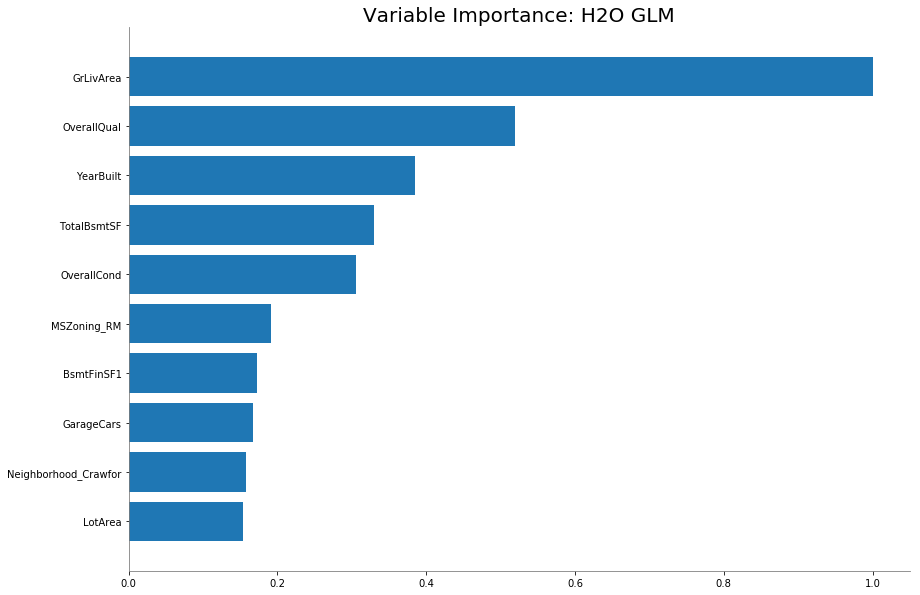

In [35]:
best_glm.varimp_plot()

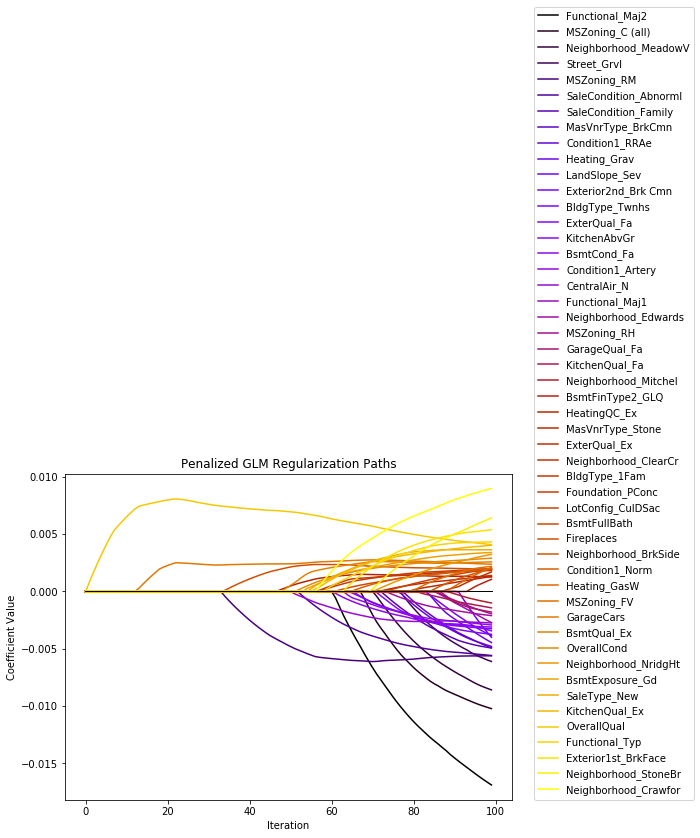

In [36]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)

reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[selected_feature].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = ax_.axhline(c='k', lw=1, xmin=0.045, xmax=0.955)
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

#### plot the partial dependence


PartialDependence: Partial Dependence Plot of model Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5 on column 'GrLivArea'.


,grlivarea,mean_response,stddev_response,std_error_mean_response
0,520.000000,11.774334,0.273992,0.007596
1,683.526316,11.815600,0.274952,0.007623
2,847.052632,11.857011,0.275916,0.007650
3,1010.578947,11.898566,0.276883,0.007676
4,1174.105263,11.940268,0.277853,0.007703
5,1337.631579,11.982115,0.278827,0.007730
6,1501.157895,12.024110,0.279804,0.007757
7,1664.684211,12.066251,0.280785,0.007785
8,1828.210526,12.108540,0.281769,0.007812
9,1991.736842,12.150978,0.282756,0.007839



PartialDependence: Partial Dependence Plot of model Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5 on column 'OverallQual'.


,overallqual,mean_response,stddev_response,std_error_mean_response
0,3.0,11.874876,0.304753,0.008449
1,4.0,11.923563,0.306002,0.008484
2,5.0,11.972449,0.307257,0.008518
3,6.0,12.021535,0.308517,0.008553
4,7.0,12.070823,0.309781,0.008588
5,8.0,12.120313,0.311052,0.008624
6,9.0,12.170006,0.312327,0.008659
7,10.0,12.219903,0.313607,0.008695



PartialDependence: Partial Dependence Plot of model Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5 on column 'YearBuilt'.


,yearbuilt,mean_response,stddev_response,std_error_mean_response
0,1872.000000,11.866576,0.330716,0.009169
1,1879.263158,11.878216,0.331041,0.009178
2,1886.526316,11.889867,0.331365,0.009187
3,1893.789474,11.901529,0.331690,0.009196
4,1901.052632,11.913202,0.332016,0.009205
5,1908.315789,11.924888,0.332341,0.009214
6,1915.578947,11.936584,0.332667,0.009223
7,1922.842105,11.948292,0.332994,0.009232
8,1930.105263,11.960012,0.333320,0.009241
9,1937.368421,11.971743,0.333647,0.009250



PartialDependence: Partial Dependence Plot of model Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5 on column 'TotalBsmtSF'.


,totalbsmtsf,mean_response,stddev_response,std_error_mean_response
0,0.000000,11.918121,0.332900,0.009229
1,138.578947,11.932441,0.333300,0.009241
2,277.157895,11.946778,0.333700,0.009252
3,415.736842,11.961132,0.334101,0.009263
4,554.315789,11.975503,0.334502,0.009274
5,692.894737,11.989891,0.334904,0.009285
6,831.473684,12.004297,0.335307,0.009296
7,970.052632,12.018720,0.335710,0.009307
8,1108.631579,12.033161,0.336113,0.009319
9,1247.210526,12.047619,0.336517,0.009330



PartialDependence: Partial Dependence Plot of model Grid_GLM_Key_Frame__upload_aa26fd4a4bc19de73f4f3ae4213649ca.hex_model_python_1593204071312_1_model_5 on column 'OverallCond'.


,overallcond,mean_response,stddev_response,std_error_mean_response
0,2.0,11.903348,0.364555,0.010107
1,3.0,11.937970,0.365615,0.010136
2,4.0,11.972693,0.366679,0.010166
3,5.0,12.007517,0.367745,0.010195
4,6.0,12.042442,0.368815,0.010225
5,7.0,12.077469,0.369887,0.010255
6,8.0,12.112598,0.370963,0.010285
7,9.0,12.147828,0.372042,0.010315


[, , , , ]

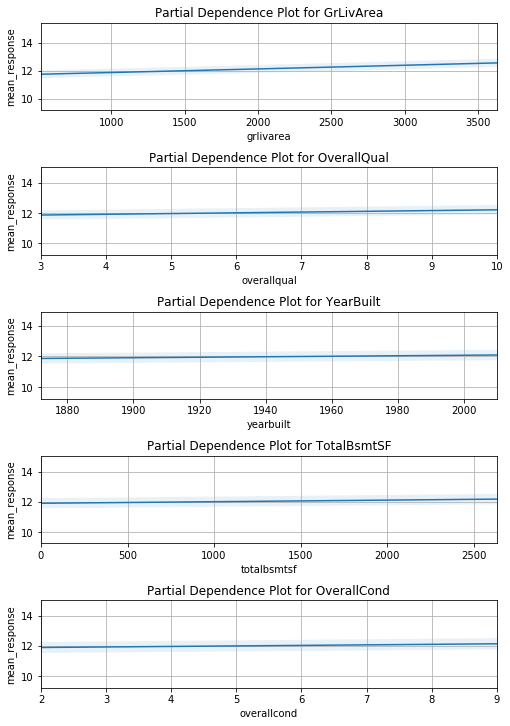

In [40]:
fes = ["GrLivArea","OverallQual","YearBuilt","TotalBsmtSF","OverallCond"]
best_glm.partial_plot(h2o.H2OFrame(train_glm),cols = fes)

### find some percentile of yhat in the validadtion data

In [41]:
#use valid set to make prediction
yhat = best_glm.predict(h2o.H2OFrame(valid_glm))

#merge
glm_yhat_valid = pd.concat([valid_glm.reset_index(drop=True),
                           yhat.as_data_frame()],
                           axis = 1)

#rename
glm_yhat_valid = glm_yhat_valid.rename(columns = {"predict":"p_SalePrice"})

#find percentile
glm_percentile_dict = explain.get_percentile_dict("p_SalePrice",glm_yhat_valid,"Id")

#display
glm_percentile_dict

{0: 376,
 10: 1012,
 20: 1146,
 30: 1161,
 40: 1400,
 50: 1094,
 60: 1436,
 70: 386,
 80: 1212,
 90: 158,
 99: 497}

#### compare the SalePrice and predicted result

In [42]:
#show the SalePrice and predicted result
glm_yhat_valid[["SalePrice","p_SalePrice"]].head(10)

,SalePrice,p_SalePrice
0,12.247694,12.225942
1,12.634603,12.511251
2,12.751300,12.857709
3,11.976659,11.905653
4,11.811547,11.776987
5,12.100156,12.157810
6,12.860999,12.790351
7,11.735269,11.733207
8,11.289782,11.366477
9,11.608236,11.629273


#### plot the comparison

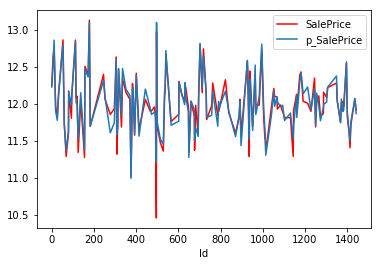

In [43]:
#'get current axis'
ax = plt.gca()

glm_yhat_valid.plot(x = "Id",y = "SalePrice",color = "red",ax=ax)
glm_yhat_valid.plot(x = "Id",y = "p_SalePrice", ax = ax)

#plt.show()

## 2.2 XGboost

In [44]:
#assign model roles
x=train_glm[x_names]
y=train_glm['SalePrice']

#set the model
model_xgb = xgb.XGBRegressor(n_estimators=1150, 
                             max_depth=3, 
                             learning_rate=0.06,
                             colsample_bytree=0.2) 

model_xgb.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.06, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1150, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

#### display the result

In [45]:
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.06, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1150, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

### Average result

#### glm prediction result for test set

In [46]:
#make prediction
p_SalePrice = best_glm.predict(h2o.H2OFrame(test_glm))
p_SalePrice = p_SalePrice.as_data_frame()

#format a new data frame
Id = test_glm["Id"]
glm = pd.DataFrame(data = Id)
glm["SalePrice"] = p_SalePrice

#make exponential
glm["SalePrice"] = np.exp(glm["SalePrice"])
    
#export csv file
glm.to_csv(r"../glm_submission.csv",index = False, header = True)

show the head of glm prediction result

In [47]:
#display the head
glm.head()

,Id,SalePrice
0,1461,120560.773383
1,1462,152791.872170
2,1463,179074.752679
3,1464,196243.091084
4,1465,193853.146869


#### xgboost prediction result for test set

In [48]:
#make prediction
test_glm.drop(columns = "Id",inplace = True)
pred_xgb=model_xgb.predict(test_glm)
pred_xgb = np.exp(pred_xgb)

#create dataframe
xgb = pd.DataFrame(data = test["Id"])
xgb["SalePrice"] = pred_xgb
xgb.to_csv(r"../xgb_submission.csv",index = False, header = True)

show the head of xgb prediction result

In [49]:
xgb.head()

,Id,SalePrice
0,1461,123675.460938
1,1462,164150.062500
2,1463,190917.453125
3,1464,201885.312500
4,1465,188592.093750


average the result

In [50]:
#calculate the average prediction result
avg_result = (xgb["SalePrice"] +glm["SalePrice"])/2
avg = pd.DataFrame(data = test["Id"])
avg["SalePrice"] = avg_result

avg.to_csv(r"../avg_submission.csv",index = False, header = True)

#### show the final output

In [52]:
avg.head(10)

,Id,SalePrice
0,1461,122118.117160
1,1462,158470.967335
2,1463,184996.102902
3,1464,199064.201792
4,1465,191222.620310
5,1466,172392.006964
6,1467,173503.748219
7,1468,165152.384785
8,1469,188471.482669
9,1470,123721.783404


## Alternative methods: Construct GBM

Thess methods are not selected to predict the test SalePrice.

#### 1. gbm with selected feature

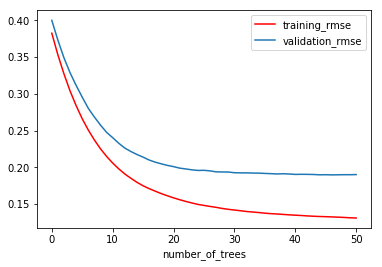

In [54]:
#gbm
pros_gbm1 = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=SEED,
                                        keep_cross_validation_predictions = True)
pros_gbm1.train(x=selected_feature, y=y_name, training_frame=h2o.H2OFrame(train_glm),validation_frame=h2o.H2OFrame(valid_glm))


#get score history
sh1 = pros_gbm1.score_history()

#set variables
x_var = "number_of_trees"
y1 = "training_rmse"
y2 = "validation_rmse"

##'get current axis'
ax = plt.gca()

sh1.plot(x = x_var,y = y1,color = "red",ax=ax)
sh1.plot(x = x_var,y = y2, ax = ax)

Use valid set to predict the result

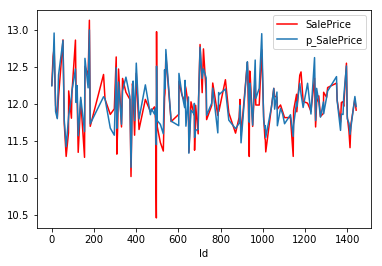

In [55]:
yhat_gbm1 = pros_gbm1.predict(h2o.H2OFrame(valid_glm))
#merge
glm_yhat_valid = pd.concat([valid_glm.reset_index(drop=True),
                           yhat_gbm1.as_data_frame()],
                           axis = 1)

#rename
glm_yhat_valid = glm_yhat_valid.rename(columns = {"predict":"p_SalePrice"})

#find percentile
glm_percentile_dict = explain.get_percentile_dict("p_SalePrice",glm_yhat_valid,"Id")

#display
glm_percentile_dict

glm_yhat_valid[["SalePrice","p_SalePrice"]].head(10)

#'get current axis'
ax = plt.gca()

glm_yhat_valid.plot(x = "Id",y = "SalePrice",color = "red",ax=ax)
glm_yhat_valid.plot(x = "Id",y = "p_SalePrice", ax = ax)

#plt.show()

#### 2. directly use gbm, with dummy variables

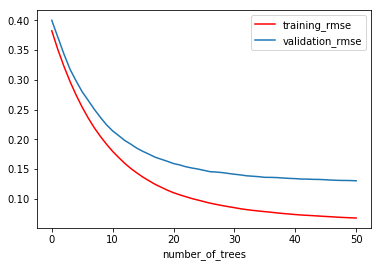

In [56]:
pros_gbm2 = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=SEED,
                                        keep_cross_validation_predictions = True)
pros_gbm2.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train_glm),validation_frame=h2o.H2OFrame(valid_glm))

#get score history
sh2 = pros_gbm2.score_history()

##'get current axis'
ax = plt.gca()

sh2.plot(x = x_var,y = y1,color = "red",ax=ax)
sh2.plot(x = x_var,y = y2, ax = ax)

yhat_gbm2 = pros_gbm2.predict(h2o.H2OFrame(valid_glm))
#merge
glm_yhat_valid2 = pd.concat([valid_glm.reset_index(drop=True),
                           yhat_gbm2.as_data_frame()],
                           axis = 1)


use valid set to get predict Sale_Price

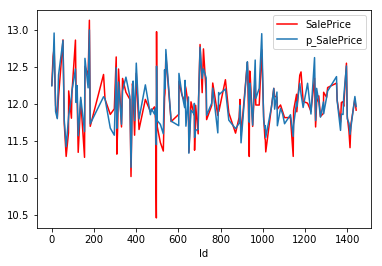

In [57]:
#rename
glm_yhat_valid2 = glm_yhat_valid.rename(columns = {"predict":"p_SalePrice"})

#find percentile
glm_percentile_dict2 = explain.get_percentile_dict("p_SalePrice",glm_yhat_valid,"Id")

#display
glm_percentile_dict2

#'get current axis'
ax = plt.gca()

glm_yhat_valid2.plot(x = "Id",y = "SalePrice",color = "red",ax=ax)
glm_yhat_valid2.plot(x = "Id",y = "p_SalePrice", ax = ax)

#plt.show()
